In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Neural Networks
import tensorflow
import keras

# AWS
import boto3

# Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Downloading Data from a Bucket

In [2]:
!ls ~/.aws

credentials


In [3]:
s3 = boto3.resource("s3")

In [22]:
# Looking at all buckets
for bucket in s3.buckets.all():
    print(bucket)

bucket = s3.Bucket("firearm-image-classification")

s3.Bucket(name='firearm-image-classification')
s3.Bucket(name='jefferson-demo-0106')


In [2]:
# prints the contents of bucket
for s3_file in bucket.objects.all():
    print(s3_file.key)

In [27]:
# Downloading all Objects in the bucket to current directory
!aws s3 sync s3://firearm-image-classification .

In [5]:
# Alters pictures
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [6]:
# Loading Images
image_gen = image_gen.flow_from_directory(
    "Data-Images",
    target_size=(300, 300),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=2591,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 2591 images belonging to 3 classes.


In [7]:
# Data Classes
image_gen.class_indices  # From directory (the way it was labeled)

{'Assault Rifle': 0, 'Handgun': 1, 'No Firearm': 2}

In [8]:
image_gen.image_shape

(300, 300, 3)

## Images and Lables

In [9]:
# split images and labels
images, labels = next(image_gen)
images.shape, labels.shape

((2591, 300, 300, 3), (2591, 3))

## Showing Images

Classes:{'Assault Rifle': 0, 'Handgun': 1, 'No Firearm': 2}
[0. 0. 1.]


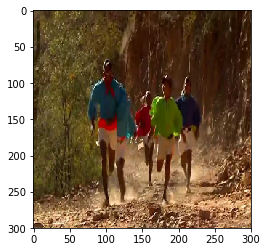

In [10]:
def show_image(n):
    
    print(f"Classes:{image_gen.class_indices}")
    plt.imshow(images[n])
    print(labels[n])
    
show_image(80)

## Train and Test Split

In [11]:
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.2, random_state=41)
X_model.shape, X_test.shape, y_model.shape, y_test.shape

((2072, 300, 300, 3), (519, 300, 300, 3), (2072, 3), (519, 3))

## Validation Set

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=41)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1657, 300, 300, 3), (415, 300, 300, 3), (1657, 3), (415, 3))

In [11]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(64, activation='relu'))  # 2nd - dense layer
cnn.add(keras.layers.Dense(2, activation='softmax'))  # 3rd - dense layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [12]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [13]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [14]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [15]:
print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440000)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                92160064  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 92,161,986
Trainable params: 92,161,986
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# This was ran 2 times for a total of 60 epochs
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=30,
               batch_size=100,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1097 samples, validate on 275 samples
Epoch 1/30
1097/1097 [==============================] - 74s 68ms/step - loss: 0.4412 - acc: 0.8095 - val_loss: 0.5482 - val_acc: 0.7273
Epoch 2/30
1097/1097 [==============================] - 75s 68ms/step - loss: 0.4329 - acc: 0.8186 - val_loss: 0.5817 - val_acc: 0.6873
Epoch 3/30
1097/1097 [==============================] - 74s 67ms/step - loss: 0.4127 - acc: 0.8496 - val_loss: 0.5720 - val_acc: 0.7273
Epoch 4/30
1097/1097 [==============================] - 74s 67ms/step - loss: 0.4218 - acc: 0.8414 - val_loss: 0.5566 - val_acc: 0.7455
Epoch 5/30
1097/1097 [==============================] - 75s 68ms/step - loss: 0.3864 - acc: 0.8569 - val_loss: 0.5374 - val_acc: 0.7382
Epoch 6/30
1097/1097 [==============================] - 74s 68ms/step - loss: 0.3549 - acc: 0.8797 - val_loss: 0.7982 - val_acc: 0.5455
Epoch 7/30
1097/1097 [==============================] - 75s 68ms/step - loss: 0.3732 - acc: 0.8687 - val_loss: 0.5986 - val_acc: 0.6945
E

In [28]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

343/343 [==============================] - 7s 20ms/step
[0.09800265907371924, 0.983591616153717] [0.523403563061539, 0.7580174803733826]


## Hyperparameter Tuning

In [16]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))


# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(15, (3, 3), 
                            activation='relu', 
                            padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten images
cnn.add(keras.layers.Flatten())

cnn.add(keras.layers.Dense(15, activation='relu'))  # 4th - dense layer
cnn.add(keras.layers.Dense(2, activation='softmax'))  # 5th - dense layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [17]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [18]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [19]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [20]:
print(cnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 15)      4335      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 15)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 84375)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)               

In [32]:
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=80,
               batch_size=100,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1082 samples, validate on 271 samples
Epoch 1/20
1082/1082 [==============================] - 138s 128ms/step - loss: 0.2964 - acc: 0.8993 - val_loss: 0.7117 - val_acc: 0.6273
Epoch 2/20
1082/1082 [==============================] - 139s 129ms/step - loss: 0.3446 - acc: 0.8632 - val_loss: 0.7515 - val_acc: 0.6199
Epoch 3/20
1082/1082 [==============================] - 139s 129ms/step - loss: 0.3428 - acc: 0.8799 - val_loss: 0.6834 - val_acc: 0.6827
Epoch 4/20
1082/1082 [==============================] - 139s 129ms/step - loss: 0.2708 - acc: 0.9057 - val_loss: 0.6069 - val_acc: 0.7085
Epoch 5/20
1082/1082 [==============================] - 139s 128ms/step - loss: 0.4449 - acc: 0.7893 - val_loss: 0.6209 - val_acc: 0.7196
Epoch 6/20
1082/1082 [==============================] - 138s 128ms/step - loss: 0.3182 - acc: 0.8882 - val_loss: 0.5806 - val_acc: 0.7232
Epoch 7/20
1082/1082 [==============================] - 139s 129ms/step - loss: 0.2133 - acc: 0.9298 - val_loss: 0.6023 - val

In [33]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

339/339 [==============================] - 10s 30ms/step
[0.09057732573718989, 0.9778188467025757] [0.4789817705970247, 0.7994100451469421]


## Conclusion
Model has improved by a high amount. Will continue to tune model for best outcome

**Difference: More layers were added; specifically more convolutional layers were added to the model.**

## Hyperparameter Tuning #2

In [78]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))


# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(15, (3, 3), 
                            activation='relu', 
                            padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten images
cnn.add(keras.layers.Flatten())


cnn.add(keras.layers.Dense(10, activation='relu'))  # 4th - convolutional layer
cnn.add(keras.layers.Dense(2, activation='softmax'))  # 5th - convolutional layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [79]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [80]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [81]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [82]:
print(cnn.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 150, 150, 15)      4335      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 75, 75, 15)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 84375)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)              

In [91]:
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=20,
               batch_size=100,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1082 samples, validate on 271 samples
Epoch 1/20
1082/1082 [==============================] - 139s 129ms/step - loss: 0.3017 - acc: 0.8909 - val_loss: 0.7043 - val_acc: 0.7011
Epoch 2/20
1082/1082 [==============================] - 139s 128ms/step - loss: 0.3207 - acc: 0.8651 - val_loss: 0.6172 - val_acc: 0.7048
Epoch 3/20
1082/1082 [==============================] - 140s 129ms/step - loss: 0.3406 - acc: 0.8521 - val_loss: 0.6735 - val_acc: 0.6863
Epoch 4/20
1082/1082 [==============================] - 140s 129ms/step - loss: 0.4262 - acc: 0.7930 - val_loss: 0.5900 - val_acc: 0.7196
Epoch 5/20
1082/1082 [==============================] - 140s 129ms/step - loss: 0.3244 - acc: 0.8558 - val_loss: 0.6154 - val_acc: 0.7085
Epoch 6/20
1082/1082 [==============================] - 139s 128ms/step - loss: 0.2909 - acc: 0.8780 - val_loss: 0.5903 - val_acc: 0.7122
Epoch 7/20
1082/1082 [==============================] - 140s 129ms/step - loss: 0.2645 - acc: 0.8993 - val_loss: 0.6640 - val

In [92]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

339/339 [==============================] - 11s 33ms/step
[0.10361980989768192, 0.9731977581977844] [0.5532034369169083, 0.7964601516723633]


## Conclusion
The first model that was tuned showed the best accuracy score.
Will now try to augment the data to see if a better score is achievable.

**Difference: The number of nodes in the 4th layer was lowered**

## Hyperparameter Tuning #3
This will not contain any augmented data

In [12]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))


# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(15, (3, 3), 
                            activation='relu', 
                            padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten images
cnn.add(keras.layers.Flatten())

# 5th - dense layer
cnn.add(keras.layers.Dense(2, activation='softmax'))

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [13]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [14]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [15]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [16]:
print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 15)      4335      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 15)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 84375)            

In [ ]:
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=80,
               batch_size=10,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1082 samples, validate on 271 samples
Epoch 1/80
1082/1082 [==============================] - 336s 311ms/step - loss: 0.6909 - acc: 0.5499 - val_loss: 0.6780 - val_acc: 0.5277
Epoch 2/80
1082/1082 [==============================] - 336s 310ms/step - loss: 0.6754 - acc: 0.5896 - val_loss: 0.6603 - val_acc: 0.6015
Epoch 3/80
1082/1082 [==============================] - 339s 313ms/step - loss: 0.6507 - acc: 0.6534 - val_loss: 0.6340 - val_acc: 0.6605
Epoch 4/80
1082/1082 [==============================] - 340s 314ms/step - loss: 0.6259 - acc: 0.6904 - val_loss: 0.8092 - val_acc: 0.4576
Epoch 5/80
1082/1082 [==============================] - 338s 312ms/step - loss: 0.6608 - acc: 0.6516 - val_loss: 0.6308 - val_acc: 0.6310
Epoch 6/80
1082/1082 [==============================] - 336s 310ms/step - loss: 0.6051 - acc: 0.6793 - val_loss: 0.6910 - val_acc: 0.6494
Epoch 7/80
1082/1082 [==============================] - 183s 169ms/step - loss: 0.6057 - acc: 0.6848 - val_loss: 0.6331 - val

In [24]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

339/339 [==============================] - 12s 35ms/step
[0.0004971204793047119, 1.0] [1.271170131576448, 0.8023598790168762]


## Conclusion
This model has out performed all the others tremendously

**Difference: An extra convolutional layer was added and a dense layer was taken off**

## Hyperparameter Tuning #4

In [21]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))


# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(15, (3, 3), 
                            activation='relu', 
                            padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten images
cnn.add(keras.layers.Flatten())

cnn.add(keras.layers.Dense(15, activation='relu'))  # 5th - dense layer
cnn.add(keras.layers.Dense(2, activation='softmax'))  # 6th - dense layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [22]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [23]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [24]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [25]:
print(cnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 15)      4335      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 15)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 84375)            

In [28]:
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=80,
               batch_size=10,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1657 samples, validate on 415 samples
Epoch 1/1
  40/1657 [..............................] - ETA: 3:56 - loss: 0.6335 - acc: 0.6667

KeyboardInterrupt: 

In [34]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

339/339 [==============================] - 13s 38ms/step
[0.0036183887377791036, 0.9981516003608704] [1.1119253373427378, 0.8082596063613892]


## Saves Model and Weights

In [18]:
# File path names
file_path_specified = 'specified_model.hdf5'
file_path_specified_weights = 'specified_weights.hdf5'

In [41]:
cnn.save(file_path_specified, overwrite=True)
cnn.save_weights(file_path_specified_weights, overwrite=True)

## Conclusion
This model performed the best with an 81%

**Differnce: A dense layer was added**

## Hyperparameter Tuning #5

In [52]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

# 3rd convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))


# 4rd - convolutional layer
cnn.add(keras.layers.Conv2D(15, (3, 3), 
                            activation='relu', 
                            padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 5th - convolutional layer
cnn.add(keras.layers.Conv2D(5, (3, 3), 
                            activation='relu', 
                            padding='SAME'))

# Flatten images
cnn.add(keras.layers.Flatten())

cnn.add(keras.layers.Dense(5, activation='relu'))  # 6th - dense layer
cnn.add(keras.layers.Dense(2, activation='softmax'))  # 7th - dense layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [53]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [54]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [55]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [56]:
print(cnn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 150, 150, 15)      4335      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 15)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 5)        

In [ ]:
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=80,
               batch_size=10,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1082 samples, validate on 271 samples
Epoch 1/80
1082/1082 [==============================] - 171s 158ms/step - loss: 0.6932 - acc: 0.4958 - val_loss: 0.6925 - val_acc: 0.5867
Epoch 2/80
1082/1082 [==============================] - 171s 158ms/step - loss: 0.6930 - acc: 0.5092 - val_loss: 0.6933 - val_acc: 0.4797
Epoch 3/80
 110/1082 [==>...........................] - ETA: 2:23 - loss: 0.6926 - acc: 0.5636

In [60]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

339/339 [==============================] - 12s 36ms/step
[0.006310267868980484, 0.996303141117096] [1.2537045802338638, 0.7905604839324951]


## Conclusion
The model did not reach the standard of the previous model, even though an extra layer was added. It seems like there could be a better neural network architecture and or more data is needed. MORE DATA IS ALWAYS NEEDED.

**Difference: An extra convolutional layer was added**

The previous model, the model above this one, will be the final model to be used.

## CNN With 3 Outputs

In [34]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))


# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(15, (3, 3), 
                            activation='relu', 
                            padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten images
cnn.add(keras.layers.Flatten())

cnn.add(keras.layers.Dense(15, activation='relu'))  # 5th - dense layer
cnn.add(keras.layers.Dense(3, activation='softmax'))  # 6th - dense layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [35]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [36]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [37]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [38]:
print(cnn.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 15)      4335      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 15)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 84375)            

In [ ]:
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=80,
               batch_size=10,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1657 samples, validate on 415 samples
Epoch 1/80
1657/1657 [==============================] - 259s 156ms/step - loss: 0.6363 - acc: 0.6659 - val_loss: 0.6308 - val_acc: 0.6667
Epoch 2/80
1657/1657 [==============================] - 259s 156ms/step - loss: 0.6262 - acc: 0.6669 - val_loss: 0.6085 - val_acc: 0.6675
Epoch 3/80
 970/1657 [================>.............] - ETA: 1:41 - loss: 0.6148 - acc: 0.6766

In [43]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

519/519 [==============================] - 18s 35ms/step
[0.001923964107382422, 0.999195396900177] [0.929022205473141, 0.8208093047142029]


## Saves Model and Weights

In [44]:
# File path names
file_path_model3 = 'model_3.hdf5'
file_path_weights3 = 'weights_3.hdf5'

In [45]:
cnn.save(file_path_model3, overwrite=True)
cnn.save_weights(file_path_weights3, overwrite=True)

## Conclusion
This model introduced 3 dependent variables (Assault Rifle, Handgun, and No Gun).

Adding a third output improved the accuracy score.

**Difference: Added an additional dependent variable, No Gun.**